## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [4]:
import string
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [9]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [10]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join([x.lower() for x in text])
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [7]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2022-12-22 19:58:09--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256,37K  1013KB/s    in 0,3s    

2022-12-22 19:58:10 (1013 KB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [11]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [12]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = dict(enumerate(tokens))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
sentences, next_tokens = [], []
for i in range(0, len(text) - 64, 1):
  sentences.append(text[i : i + 64])
  next_tokens.append(text[i + 64])

print("Number of sequences:", len(sentences))
x = np.zeros((len(sentences), 64, len(tokens)))
y = np.zeros((len(sentences), len(tokens)))
for i, sentence in enumerate(sentences):
  for t, token in enumerate(sentence):
    x[i, t, token_to_idx[token]] = 1
  y[i, token_to_idx[next_tokens[i]]] = 1

# dict <char>:<index>
# Your great code here

Number of sequences: 100161


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [13]:
class VanillaRNN(nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 128, emb_dim = 128,
                 n_layers = 1):
        super(VanillaRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = n_tokens
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.rnn = nn.RNN(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.dropout  = nn.Dropout(.35)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, h_prev):
        h_seq, h = self.rnn(self.embed(x), h_prev)
        h_seq = self.dropout(h_seq)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

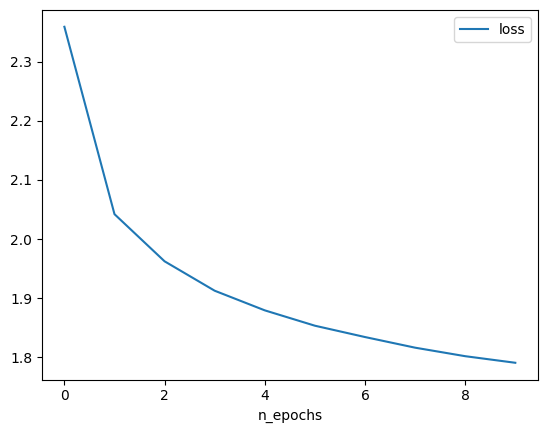

Loss after the epoch # 11 1.7817878888203547
Loss after the epoch # 12 1.772978074122698
Loss after the epoch # 13 1.7601071235461112
Loss after the epoch # 14 1.7556035995483399
Loss after the epoch # 15 1.7474428824889354


In [14]:
# Your plot code here
batch_size = 512
model_rnn = VanillaRNN()
opt = torch.optim.Adam(model_rnn.parameters())
model_rnn.to(device)
criterion = nn.CrossEntropyLoss()

n_epochs = 15
history = []
model = model_rnn.train()

for epoch in range(n_epochs):
    ep_history = []
    hidden_state = model_rnn.initial_state(batch_size)
    for batch_ind in range(batch_size, x.shape[0], batch_size):
      opt.zero_grad()
      x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
      y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
      seq, hidden_state = model_rnn(x_batch, hidden_state)
      loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
      loss.backward()
      opt.step()  
      ep_history.append(loss.item())
      hidden_state = hidden_state.detach()
    history.append(np.mean(ep_history))
    print("Loss after the epoch # {}".format(epoch + 1), history[-1])
    if (epoch + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history, label = 'loss')
        plt.xlabel("n_epochs")
        plt.legend()
        plt.show()

In [16]:
def generate_text(char_rnn, tokens = tokens, seed_phrase = 'fucking society! ', 
                    max_length = 100, temperature = 1., flag = False):
  
    def sample(preds, tokens, temperature = 1.):
        preds =  F.softmax(preds / temperature, dim = -1).cpu().data.numpy().squeeze()
        next_ix = np.random.choice(len(tokens), p = preds)
        return torch.LongTensor([[next_ix]])

    x_sequence = torch.Tensor([np.array([token_to_idx[token] for token in seed_phrase.lower()])]).to(device)
    hid_state = char_rnn.initial_state(batch_size = 1)

    if flag: hid_state = tuple([each.data for each in hid_state])
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, i].long()]), hid_state)
    
    for i in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, -1].long()]), hid_state)
        next_ix = sample(out, tokens, temperature)

        x_sequence = torch.cat([x_sequence, next_ix.to(device)], dim = 1)
    return ''.join([tokens[int(ix)] for ix in x_sequence.cpu().data.numpy()[0]])

In [17]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
import warnings
warnings.filterwarnings("ignore")
model = model_rnn.eval()
print(generate_text(char_rnn = model_rnn,  max_length = 500, temperature = 1.))

fucking society! the leviiom the musind, feary,
  i hepied.
  if shale thou my sore;
  o! mbarakes fait.,
  in what pace in love i epit,
  and thet soack date ofs,
  and will musiselo,
  thy bevill,
  they so ary banking essind speat, do thou be.

    butr pleast
  thee i not his doth for eerin
  stoamting thine hath they my pres,
  and my dears on thio 'oft thy istanee that but of tre bjbe taingn-soousto! so my fate,
  and self i stell each thing bid, stell wittel he add, theign'd thouep theus 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

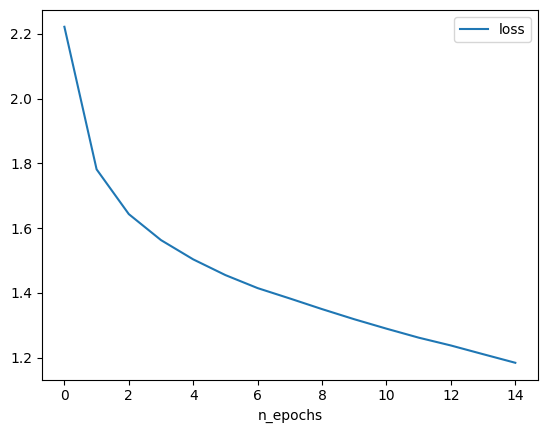

In [18]:
# Your beautiful code here
class LSTM (nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 256, emb_dim = 128,
                 n_layers = 1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = emb_dim
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, hidden_state):
        out, hidden_state = self.lstm(self.embed(x), hidden_state)
        out = self.hid_to_logits(out)
      
        return out, hidden_state
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

model_lstm = LSTM()
opt = torch.optim.Adam(model_lstm.parameters())
model_lstm.to(device)
criterion = nn.CrossEntropyLoss()

n_epochs = 15
history = []
model = model_lstm.train()
for epoch in range(n_epochs):
  ep_history = []
  hidden_state = model_lstm.initial_state(batch_size)
  for batch_ind in range(batch_size, x.shape[0], batch_size):
    x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
    y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
    hidden_state = tuple([each.data for each in hidden_state])
    opt.zero_grad()
    seq, hidden_state = model_lstm(x_batch, hidden_state)
    loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
    loss.backward()
    opt.step()  
    ep_history.append(loss.item())
  history.append(np.mean(ep_history))
  print("Loss after the epoch # {}".format(epoch + 1), history[-1])

  if (epoch + 1) % 5 == 0:
      clear_output(True)
      plt.plot(history, label = 'loss')
      plt.xlabel("n_epochs")
      plt.legend()
      plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [19]:
# Text generation with different temperature values here
model = model_lstm.eval()
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print("TEMPERATURE = ", temperature)
  poetry = generate_text(char_rnn = model_lstm, temperature = temperature,
                      max_length = 400, seed_phrase = "Listen, Bitch! ")

  print('\t', poetry, '\n')

TEMPERATURE =  0.1
	 listen, bitch! that i have story despise,
  that i have swear that thou art thou art the days,
  when i thou art thou art thou art thou desire,
  that i have sweet thou art thou art thou desire,
  that i when thou art thou art thou mayst true show,
    and thou art thou art thou art thou dost thou art bear,
  and therefore thou art thou art thou art thou desire,
  that i have sweet thou art thou a 

TEMPERATURE =  0.2
	 listen, bitch! if thou dost despise,
    that which i thy heart thou art for my sight,
  and the world count thou art thou mayst thou dost despise,
    that i whom thou my love thee my love thee my heart,
  and thou may thy self the sad thou mayst to me,
  and therefore that thou art thou art thou dost thee thee,
  and therefore thou art thou art thou art thou desire.
    then thou dost thou fair  

TEMPERATURE =  0.5
	 listen, bitch! that i do fair,
    and they should the mine eyes would dead thine eyes and excess
  and prove that my heart thou ma

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [20]:
# Saving and loading code here
def save_net(net, name: str, opt):
    checkpoint = {'state_dict': net.state_dict(),
                  'opt_state_dict': opt.state_dict()}

    with open(name, 'wb') as f:
        torch.save(checkpoint, f)

save= save_net(model_lstm, "Sh_LSTM.net", opt)
checkpoint = torch.load("Sh_LSTM.net")
model_lstm.load_state_dict(checkpoint['state_dict'])
opt.load_state_dict(checkpoint['opt_state_dict'])
model = model_lstm.eval()
print(generate_text(char_rnn = model_lstm, temperature = 1.,
                      max_length = 450, seed_phrase = "Listen, You! "))

listen, you! full if thy self i doth knight full, be,
    and yet a keep there i sent, glive true days;
  to bare thou knows frop thou master, or my mis,
  hand carted any, and will by not foun this hells.
  if less aught not be thou happy for thee,
  drophame, i conounly o'er, may not be decesent:
  but to know one is is not so long eyess goven
  full mad addel i greet mad men of true:
  i'vit copoun'd, and where i with foost,
  which laid knoug


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)